In [1]:
library(ArchR)
library(tidyverse)
library(BSgenome.Hsapiens.UCSC.hg38)
library(SingleCellExperiment)
library(anndata)
# library(sceasy)
# library(reticulate)
# use_condaenv('cellpymc')
# loompy <- reticulate::import('loompy')


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .______      
          /   \     |   _ 

In [2]:
setwd('/nfs/team205/heart/anndata_objects/8regions/ArchR')
getwd()

[1] "/nfs/team205/heart/anndata_objects/8regions/ArchR"

In [3]:
# before starting a project we must set the ArchRGenome and default threads for parallelization.
# Setting default genome to Hg38.
addArchRGenome("hg38")

Setting default genome to Hg38.



In [4]:
# Setting default number of Parallel threads to 16
addArchRThreads(threads = 10) 

Setting default number of Parallel threads to 10.



# Read in ArchR project

In [5]:
archr_project_path = '/nfs/team205/heart/anndata_objects/8regions/ArchR/project_output'
proj = loadArchRProject(path = archr_project_path, showLogo = FALSE)
proj

Successfully loaded ArchRProject!


           ___      .______        ______  __    __  .______      
          /   \     |   _  \      /      ||  |  |  | |   _  \     
         /  ^  \    |  |_)  |    |  ,----'|  |__|  | |  |_)  |    
        /  /_\  \   |      /     |  |     |   __   | |      /     
       /  _____  \  |  |\  \\___ |  `----.|  |  |  | |  |\  \\___.
      /__/     \__\ | _| `._____| \______||__|  |__| | _| `._____|
    



class: ArchRProject 
outputDirectory: /nfs/team205/heart/anndata_objects/8regions/ArchR/project_output 
samples(47): HCAHeart9508627_HCAHeart9508819
  HCAHeart9508628_HCAHeart9508820 ...
  HCAHeartST13180618_HCAHeartST13177115
  HCAHeartST13180619_HCAHeartST13177116
sampleColData names(1): ArrowFiles
cellColData names(52): Sample TSSEnrichment ... Gex_MitoRatio
  Gex_RiboRatio
numberOfCells(1): 139835
medianTSS(1): 8.699
medianFrags(1): 9459

# Prepare Peak annotation

In [6]:
# gets peak annotation matches from a given ArchRProject.
peakmeta = getMatches(proj)
peakmeta

class: RangedSummarizedExperiment 
dim: 429828 870 
metadata(0):
assays(1): matches
rownames(429828): vCM3_stressed LYVE1+MP_cycling ... vCM3_stressed FB3
rowData names(13): score replicateScoreQuantile ... idx N
colnames(870): TFAP2B_1 TFAP2D_2 ... TBX18_869 TBX22_870
colData names(0):

In [7]:
# get peak-by-TFmotif matrix (boolean type)
peak_motif_mtx <- assays(peakmeta)[['matches']]
rownames(peak_motif_mtx) <- rowRanges(peakmeta) %>% {paste0(seqnames(.), "_", start(.), "-", end(.))}
peak_motif_mtx[1:5,1:5]

5 x 5 sparse Matrix of class "lgCMatrix"
                   TFAP2B_1 TFAP2D_2 TFAP2C_3 TFAP2E_4 TFAP2A_5
chr1_794932-795432        .        .        .        .        .
chr1_817104-817604        .        .        .        .        .
chr1_818775-819275        .        .        .        .        .
chr1_819697-820197        .        .        .        .        .
chr1_821364-821864        .        .        .        .        .

# Read in pre-calculated peak2gene dataframe

In [8]:
table(proj$cell_type)


                 Adipocyte       Atrial Cardiomyocyte 
                      1374                      14163 
          Endothelial cell                 Fibroblast 
                     16104                      42479 
Lymphatic Endothelial cell                   Lymphoid 
                       334                       4399 
                 Mast cell           Mesothelial cell 
                       274                         62 
                Mural cell                    Myeloid 
                     10121                      13660 
               Neural cell  Ventricular Cardiomyocyte 
                      1581                      35284 

In [14]:
celltype_to_analyse = 'Atrial Cardiomyocyte'

In [16]:
p2geneDF = read.csv(paste0('/nfs/team205/heart/anndata_objects/8regions/ArchR/project_output/csv/peak2gene/',
                           sub(' ','',celltype_to_analyse),'.csv'))
dim(p2geneDF)
head(p2geneDF)

[1] 3815446       8

,idxATAC,idxRNA,Correlation,FDR,VarQATAC,VarQRNA,geneName,peakName
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,1,10,-0.020401580,0.7933998,0.02826247,0.1150766,AC114498.1,chr1_794932-795432
2,2,10,0.033200608,0.6492725,0.49832491,0.1150766,AC114498.1,chr1_817104-817604
3,3,10,-0.047132556,0.4919864,0.68155634,0.1150766,AC114498.1,chr1_818775-819275
4,4,10,0.001703915,0.9847709,0.39796384,0.1150766,AC114498.1,chr1_819697-820197
5,5,10,0.027802571,0.7105859,0.51944266,0.1150766,AC114498.1,chr1_821364-821864
6,6,10,0.058411057,0.3736228,0.55871186,0.1150766,AC114498.1,chr1_825517-826017


# Generate "TF - possible downstream genes" dictionary

In [56]:
# arguments
p2g_corr_thresh = 0.4
p2g_FDR_thresh = 1e-04

In [57]:
# generate dictionary
network = list() 

# filter peaks
df <- p2geneDF[which((p2geneDF[['Correlation']]>p2g_corr_thresh)==TRUE),]
df <- df[which((df[['FDR']]<p2g_FDR_thresh)==TRUE),]

TFs = strsplit(colnames(peak_motif_mtx),'_')%>%lapply(function(x){x}[1])%>%unlist()
for(tf in TFs){
    tf_peaks = rownames(peak_motif_mtx)[which(peak_motif_mtx[,which(TFs==tf)] == TRUE)]
    network[[tf]] = df[which((df[['peakName']] %in% tf_peaks)==TRUE),] %>% pull(geneName)
}

In [60]:
length(network)

[1] 870

In [61]:
length_vector = c()
for(tf in names(network)){
    length_vector = c(length_vector,length(network[[tf]]))
}

In [62]:
length_vector

[1]  2620  5849  5149  1996  2587  3123   614   989   875  1351   736  2211
 [13]   414  1509   577   952  1336  1046   868  1080  1808  1752  3537   936
 [25]   814  1655  1032  1336   595   971   444  1205  1572  1866  1027  2774
 [37]  1219  2717   881  1654  4004  2561   324   636   285  1514  1027  2867
 [49]   444   874   872  1268   455   996  1739  4454   605  2374   444  1598
 [61]   444  1322  3473   327  1007  1572  4468  1104  2257  2518  1738  1173
 [73]   255  2745  2717  2883   202   807   317  2843   481  1520  1078   400
 [85]   280   340   372  1672  2052   270  1750   881  1514  2257  1073  1514
 [97]  2513   967  1700   283   660   444  1683  1003  2925  1075   289  1353
[109]   613   268  1003   381  2386   132  2509  1368   746   726  2526   663
[121]  2317   817  1215  3025  1650  1003   807   384  1358  2543   933  1235
[133]   406   420   542  2660  2809   658  3075   812  1111  3061  2818  1324
[145]   942  3320  1640   708  2235  1518   542   905   542   542  1016   144
[157]  2373  7419 10646  1585  2229  2193  3133  3060  5083  6211  1897  2990
[169]   886  2105  3564  6154  1773  2999  9028  1598  4356 11494  5709  4474
[181]   452  1837  1188  2579  1538  2370  1672   862  4675  3564  3320   130
[193]   587  3883  4797  2326  1201  4822  3130  5389  1860  1320   779  1303
[205]  6778  1814  2394  8196  4679  2640  1091   863  1126  1303  1959   897
[217]   395  1084  2093  1294  4874 10243  8329  1091   908  5315   628  1134
[229]  5129  1976  1992 10009   744   488  1098  2482   520  1660  2341  1492
[241]  5315  1067  1739  1611   299   540  7005  3434  1220  1094  3618  2646
[253]  2495  1732   713  3946  1385  6969  1325  1537  1537   682  1720  4980
[265]  1000  7944  9795  1270  3461  1201  1785  2093   846  1069  4492   846
[277]  1089   862  4492   848   848  1085  5315  1178   848   848   848  1635
[289]   306  1508  1907   314   717   162   757   992  1118   292   130   468
[301]  3602   118   588   481   519   572   774   955   955   955   400   258
[313]   576  1030   442   703  3887  2266  1023   956  1767  4764  1357   943
[325]  1086  3678  1071   996  2287   568  1091  1036  1192  1680  1934  1900
[337]  1105  1730  1008  3569  1940  1140   963  1880   830   906   948  1032
[349]  1017  2139  1564  2240   738   770  1653  1412  1303   738   886   950
[361]   498   967  1324  1076  2055  1954  1164   498   408   681  2356  1545
[373]  1506  1283  1929   770  2410   738   569  1215  1076   770  1361  1267
[385]  1245  1341   938  1499   466   573   306  2258  2897   660   611   393
[397]   432   696   643   659   557   608   445   998   452   702   414   456
[409]   401   754  1179   505   435   640   295   875   529  1009   308   487
[421]   528   349   243   855  1049   719   671   528   445   532   574  1131
[433]   373   489  1100   616   347   445   310   353  1308   387   842   618
[445]   633   700   580   951   659   581   396  1175   402  1147   470   517
[457]  1169   985   355   299   391   947  1237   345  1067   765   788   884
[469]   702   601  1015   470   849   300   982  1818   296   838   367   433
[481]   374   400   518   329   353  1760   432   367   310   495   529  1275
[493]   356   897   489   748  1673   649   351   404   677  1367   396  2164
[505]  1049   487   746   406   566   161  1434   640  1796  1082   562   560
[517]   667  1918   353   503   353   539   408  1167   310   884   549   461
[529]  1125   481   988   469   353   294   642   353  1397  1275   600  1122
[541]  1499   884   409   930   632   751   673  1072   696  1880   772   513
[553]   494   590   579   353   652   787   499   478  1612   703   927   711
[565]   407   927   332   286   708   823   823   823   927   823   927   823
[577]   708   823   823   823   823   823   823   433   823   823   823   823
[589]   927   823   823   823   823   823  1310   823   509   823   927   927
[601]   823   823   823   493   198   454   267   366  1072   984  1100   630
[613]   908  1039  1132 

In [71]:
library(jsonlite)
write_json(network,
           paste0('/nfs/team205/heart/anndata_objects/8regions/ArchR/project_output/TF_downstreamGene/',
                    sub(' ','',celltype_to_analyse),'_p2gCorr-',p2g_corr_thresh,'.json')
          )

In [72]:
paste0('/nfs/team205/heart/anndata_objects/8regions/ArchR/project_output/TF_downstreamGene/',
                    sub(' ','',celltype_to_analyse),'_p2gCorr-',p2g_corr_thresh,'.json')

[1] "/nfs/team205/heart/anndata_objects/8regions/ArchR/project_output/TF_downstreamGene/AtrialCardiomyocyte_p2gCorr-0.4.json"

In [66]:
'HCN1' %in% network[['FOXP2']]

[1] TRUE

In [68]:
length_vector

[1]  2620  5849  5149  1996  2587  3123   614   989   875  1351   736  2211
 [13]   414  1509   577   952  1336  1046   868  1080  1808  1752  3537   936
 [25]   814  1655  1032  1336   595   971   444  1205  1572  1866  1027  2774
 [37]  1219  2717   881  1654  4004  2561   324   636   285  1514  1027  2867
 [49]   444   874   872  1268   455   996  1739  4454   605  2374   444  1598
 [61]   444  1322  3473   327  1007  1572  4468  1104  2257  2518  1738  1173
 [73]   255  2745  2717  2883   202   807   317  2843   481  1520  1078   400
 [85]   280   340   372  1672  2052   270  1750   881  1514  2257  1073  1514
 [97]  2513   967  1700   283   660   444  1683  1003  2925  1075   289  1353
[109]   613   268  1003   381  2386   132  2509  1368   746   726  2526   663
[121]  2317   817  1215  3025  1650  1003   807   384  1358  2543   933  1235
[133]   406   420   542  2660  2809   658  3075   812  1111  3061  2818  1324
[145]   942  3320  1640   708  2235  1518   542   905   542   542  1016   144
[157]  2373  7419 10646  1585  2229  2193  3133  3060  5083  6211  1897  2990
[169]   886  2105  3564  6154  1773  2999  9028  1598  4356 11494  5709  4474
[181]   452  1837  1188  2579  1538  2370  1672   862  4675  3564  3320   130
[193]   587  3883  4797  2326  1201  4822  3130  5389  1860  1320   779  1303
[205]  6778  1814  2394  8196  4679  2640  1091   863  1126  1303  1959   897
[217]   395  1084  2093  1294  4874 10243  8329  1091   908  5315   628  1134
[229]  5129  1976  1992 10009   744   488  1098  2482   520  1660  2341  1492
[241]  5315  1067  1739  1611   299   540  7005  3434  1220  1094  3618  2646
[253]  2495  1732   713  3946  1385  6969  1325  1537  1537   682  1720  4980
[265]  1000  7944  9795  1270  3461  1201  1785  2093   846  1069  4492   846
[277]  1089   862  4492   848   848  1085  5315  1178   848   848   848  1635
[289]   306  1508  1907   314   717   162   757   992  1118   292   130   468
[301]  3602   118   588   481   519   572   774   955   955   955   400   258
[313]   576  1030   442   703  3887  2266  1023   956  1767  4764  1357   943
[325]  1086  3678  1071   996  2287   568  1091  1036  1192  1680  1934  1900
[337]  1105  1730  1008  3569  1940  1140   963  1880   830   906   948  1032
[349]  1017  2139  1564  2240   738   770  1653  1412  1303   738   886   950
[361]   498   967  1324  1076  2055  1954  1164   498   408   681  2356  1545
[373]  1506  1283  1929   770  2410   738   569  1215  1076   770  1361  1267
[385]  1245  1341   938  1499   466   573   306  2258  2897   660   611   393
[397]   432   696   643   659   557   608   445   998   452   702   414   456
[409]   401   754  1179   505   435   640   295   875   529  1009   308   487
[421]   528   349   243   855  1049   719   671   528   445   532   574  1131
[433]   373   489  1100   616   347   445   310   353  1308   387   842   618
[445]   633   700   580   951   659   581   396  1175   402  1147   470   517
[457]  1169   985   355   299   391   947  1237   345  1067   765   788   884
[469]   702   601  1015   470   849   300   982  1818   296   838   367   433
[481]   374   400   518   329   353  1760   432   367   310   495   529  1275
[493]   356   897   489   748  1673   649   351   404   677  1367   396  2164
[505]  1049   487   746   406   566   161  1434   640  1796  1082   562   560
[517]   667  1918   353   503   353   539   408  1167   310   884   549   461
[529]  1125   481   988   469   353   294   642   353  1397  1275   600  1122
[541]  1499   884   409   930   632   751   673  1072   696  1880   772   513
[553]   494   590   579   353   652   787   499   478  1612   703   927   711
[565]   407   927   332   286   708   823   823   823   927   823   927   823
[577]   708   823   823   823   823   823   823   433   823   823   823   823
[589]   927   823   823   823   823   823  1310   823   509   823   927   927
[601]   823   823   823   493   198   454   267   366  1072   984  1100   630
[613]   908  1039  1132 

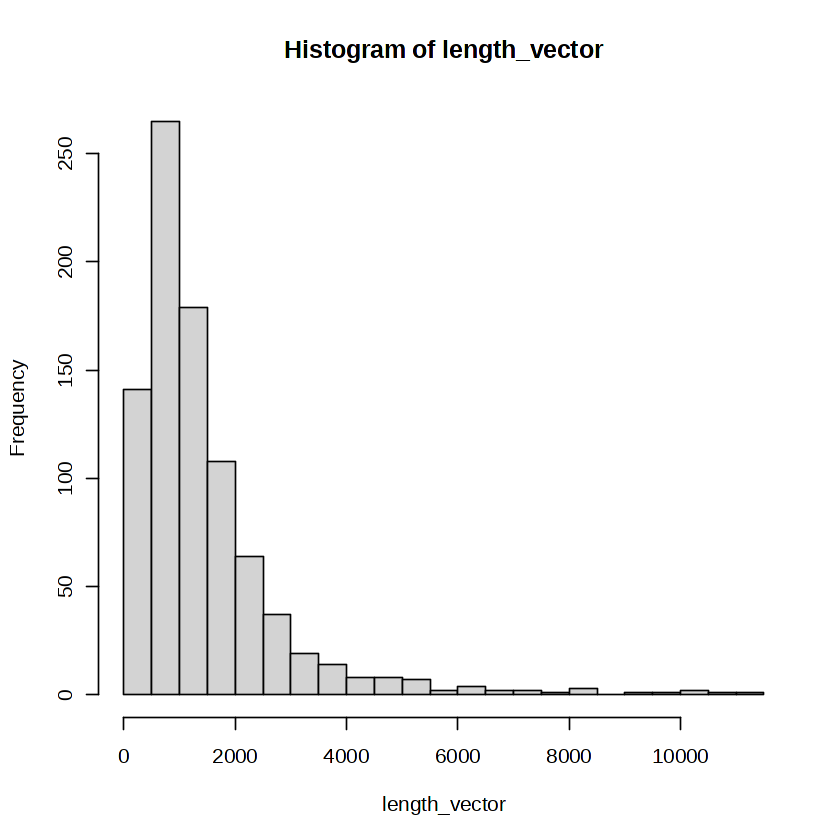

In [69]:
hist(length_vector, breaks=30)